In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from lightgbm import LGBMModel,LGBMClassifier
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold


In [2]:
train_df = pd.read_csv('../input/tabular-playground-series-apr-2021/train.csv')
test_df = pd.read_csv('../input/tabular-playground-series-apr-2021/test.csv')

In [3]:
def label_encoder(c):
    lc = LabelEncoder()
def age_range(age):
    if age >= 0 and age <= 5:
        return "baby"
    elif age >= 6 and age <= 16:
        return "children"
    elif age >= 17 and age <= 29:
        return "young_adult"
    elif age >= 30 and age <=49:
        return "middle_aged"
    else:
        return "senior"
    return lc.fit_transform(c)
def preprocess(df):
    age_map = df[['Age', 'Pclass']].dropna().groupby('Pclass').mean().to_dict()
    df.Age = df.Age.fillna(df.Pclass.map(age_map['Age']))
    df.Cabin = df.Cabin.fillna('X').map(lambda x: x[0].strip())
    df.Ticket = df.Ticket.fillna('X').map(lambda x:str(x).split()[0] if len(str(x).split()) > 1 else 'X')
    df.Fare = df.Fare.fillna(df.Fare.mean())
    df.Fare = df.Fare.map(lambda i: np.log(i) if i > 0 else 0)
    df.Embarked = df.Embarked.fillna('X')
    df.Name = df.Name.map(lambda x: x.split(',')[0])
    df["age_range"] = df["Age"].apply(age_range)
    df["Family"] = df["SibSp"] + df["Parch"] +1   
    df["Alone"] =  df["Family"].map(lambda x : "Yes" if x == 1 else "No")
    label_cols = ['Name']
    onehot_cols = ['Pclass', 'Sex', 'Cabin', 'Embarked']
    numerical_cols = ['SibSp', 'Parch', 'Fare','Survived',"Family","Age"]  
    onehot_encoded_df = pd.get_dummies(df[onehot_cols])
    label_encoded_df = df[label_cols].apply(label_encoder)
    numerical_df = df[numerical_cols]
    return pd.concat([numerical_df,onehot_encoded_df], axis=1)

def test_preprocess(df):
    age_map = df[['Age', 'Pclass']].dropna().groupby('Pclass').mean().to_dict()
    df.Age = df.Age.fillna(df.Pclass.map(age_map['Age']))
    df.Cabin = df.Cabin.fillna('X').map(lambda x: x[0].strip())
    df.Ticket = df.Ticket.fillna('X').map(lambda x:str(x).split()[0] if len(str(x).split()) > 1 else 'X')
    df.Fare = df.Fare.fillna(df.Fare.mean())
    df.Fare = df.Fare.map(lambda i: np.log(i) if i > 0 else 0)
    df.Embarked = df.Embarked.fillna('X')
    df.Name = df.Name.map(lambda x: x.split(',')[0])
    df["age_range"] = df["Age"].apply(age_range)
    df["Family"] = df["SibSp"] + df["Parch"] +1   
    df["Alone"] =  df["Family"].map(lambda x : "Yes" if x == 1 else "No")
    label_cols = ['Name']
    onehot_cols = ['Pclass', 'Sex', 'Cabin', 'Embarked']
    numerical_cols = ['SibSp', 'Parch', 'Fare',"Family","Age"]  
    onehot_encoded_df = pd.get_dummies(df[onehot_cols])
    label_encoded_df = df[label_cols].apply(label_encoder)
    numerical_df = df[numerical_cols]
    return pd.concat([numerical_df,onehot_encoded_df], axis=1)


In [4]:
persudo = pd.read_csv("../input/apr-play-ground-persudo/persudosubmit.csv")

In [5]:
train = preprocess(df = train_df)
test = test_preprocess(df=test_df)
persudo_test = test.copy()
persudo_test['Survived'] = persudo["Survived"]
full_df = train.append(persudo_test)
y = full_df.pop("Survived")
x = full_df


In [6]:
 params =  {'learning_rate': 0.08200889474481012,
  'min_data_in_leaf': 100,
  'lambda_l1': 0.1333381789860702,
  'lambda_l2': 2.3426839157687394e-07,
  'num_leaves': 62,
  'max_depth': 9,
  'feature_fraction': 0.9571499822515682,
  'bagging_fraction': 0.9512400407806436,
  'bagging_freq': 5,
  'max_bin': 200}

In [7]:
test_acc = LGBMClassifier(**params)
sk_fold = StratifiedKFold(5)
print(cross_val_score(test_acc,x,y, n_jobs=-1, cv=sk_fold,scoring='accuracy').mean())
print(cross_val_score(test_acc,x,y, n_jobs=-1, cv=sk_fold,scoring='f1').mean())

0.87951
0.8402202705923916


[LightGBM] [Warning] lambda_l1 is set=0.1333381789860702, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1333381789860702
[LightGBM] [Warning] bagging_fraction is set=0.9512400407806436, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9512400407806436
[LightGBM] [Warning] lambda_l2 is set=2.3426839157687394e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3426839157687394e-07
[LightGBM] [Warning] feature_fraction is set=0.9571499822515682, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9571499822515682
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

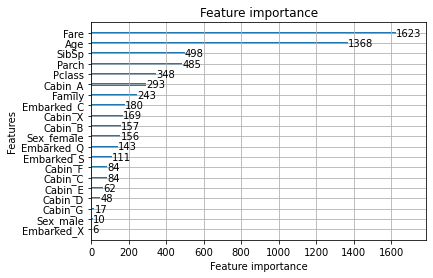

In [8]:
model = LGBMClassifier(**params)
model.fit(x,y)
lgb.plot_importance(model)

In [9]:
clf = LGBMClassifier(**params)
clf.fit(x,y)

LGBMClassifier(bagging_fraction=0.9512400407806436, bagging_freq=5,
               feature_fraction=0.9571499822515682,
               lambda_l1=0.1333381789860702, lambda_l2=2.3426839157687394e-07,
               learning_rate=0.08200889474481012, max_bin=200, max_depth=9,
               min_data_in_leaf=100, num_leaves=62)

In [10]:
preds = clf.predict(test)

In [11]:
submit = pd.DataFrame({"PassengerId":test_df["PassengerId"],"Survived":preds})
submit.head(10)

,PassengerId,Survived
0,100000,0
1,100001,1
2,100002,1
3,100003,0
4,100004,1
5,100005,0
6,100006,1
7,100007,0
8,100008,1
9,100009,0


In [12]:
submit.to_csv("submission.csv",index = False)